# Aperture Photometry Example

Following in part this series of tutorials by [Micah Laing](https://www.youtube.com/@mic_n_ike)

1. [Astropy Lesson 1: Introduction to FITS File Handling](https://www.youtube.com/watch?v=_DzSIeruotQ) - I didn't do the start of this as using a different Jupyter Hub.
2. [Astropy Lesson 2: Photutils.detection](https://www.youtube.com/watch?v=vxMoG2K_n5o)
3. [Astropy Lesson 3: Aperture Photometry](https://www.youtube.com/watch?v=8162hq_5ZkQ) - didn't do the end as it's about calibration of HST images. 

I didn't need to install things because I did it on a [SciServer Astronomy](https://www.sciserver.org/) Compute Image. All the import statements also work on `python3.10.10` kernel on the Haverford Jupyter Hub (as of Nov 2024).

- Karen Masters (for ASTR341 Class). 

First: 
1. Use AIJ to calibrate and align the two filters of images for your cluster (if using this for cluster photometry). 
Optional: You can WCS solve and then you can use SkyApertures. 
2. Don't forget to align the two median aligned images (you want the stars in the same pixel in both images to make the below easier)
3. Measure the size of a star in pixels (use AIJ to tell you the optimal aperture to use)
![image](Seeing_Profile_rband.png)

4. You then need to put the aligned calibrated fits images on the server you are running this code on....

I actually had three filters, so I made a three colour image! 

![image](RGB_NGC884.jpg)



In [1]:
import numpy as np

from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #Capitals matter

from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
#I found that Aperture_photometry is now photometry. I can't get ApertureStats to load
from photutils.aperture import ApertureStats

In [2]:
fits_file = fits.open('aligned_ngc884_MED_aligned_r.fits')

In [3]:
print(fits_file)

In [4]:
image_data=fits_file[0].data

In [5]:
print(image_data)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.9408549e-02
  8.6290978e-02 7.2399050e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.2746116e+00
  1.3850836e+00 1.1620998e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.9674049e+01
  8.6103615e+01 9.1312141e+01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.8318642e+01
  9.7988335e+01 1.0448777e+02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.3235046e+01
  8.4769379e+01 9.1875114e+01]]


<function matplotlib.pyplot.show(close=None, block=None)>

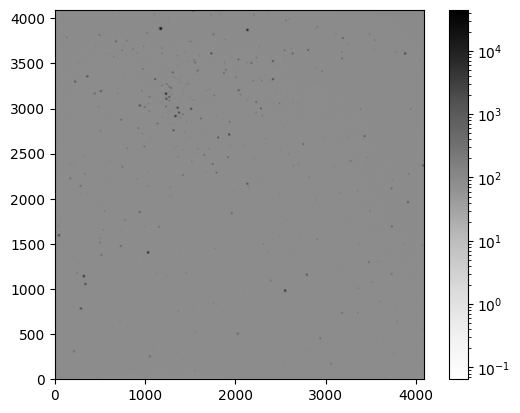

In [6]:
plt.figure()
plt.imshow(image_data,origin='lower',norm=LogNorm(),cmap='Greys')
plt.colorbar()
plt.show

## To select a section of the image

<function matplotlib.pyplot.show(close=None, block=None)>

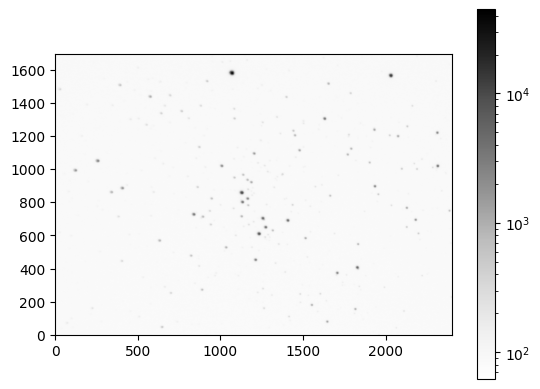

In [7]:
section1 = image_data[2300:4000, 100:2500]
plt.figure()
plt.imshow(section1,origin='lower',norm=LogNorm(),cmap='Greys')
plt.colorbar()
plt.show

## Using DAO Star Finder

I did the entire image not the section as in the tutorial. 

Why sigma clipped? It removes extreme outliers. 

In [8]:
mean,median,std=sigma_clipped_stats(section1,sigma=3.0)

In [9]:
print(mean,median,std)

84.81141 84.67498 4.6338115


In [10]:
daofind=DAOStarFinder(fwhm=5.0,threshold=8.0*std) #FWHM = 8 is the size of a star in our image
sources=daofind(section1-median)

for col in sources.colnames:
    if col not in ('id','npix'):
        sources[col].info.format='%.2f'
        
sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1   1958.44      1.60      0.53      -0.05 ... 0.00    74.62   2.26 -0.89
  2   2063.21     42.75      0.37      -0.13 ... 0.00    95.06   2.09 -0.80
  3    648.36     47.95      0.41      -0.07 ... 0.00   516.47   7.70 -2.22
  4     74.73     72.40      0.30      -0.19 ... 0.00    92.20   1.37 -0.34
  5    740.22     79.53      0.48      -0.04 ... 0.00    57.31   1.06 -0.06
  6   1646.38     80.34      0.41      -0.13 ... 0.00  1380.79  27.15 -3.58
  7   1421.10     87.13      0.54      -0.38 ... 0.00    54.51   1.14 -0.14
  8    509.73    110.94      0.35      -0.07 ... 0.00    83.07   1.38 -0.35
  9   1414.90    110.89      0.38      -0.20 ... 0.00   245.79   5.11 -1.77
 10   1810.26    129.72      0.45      -0.18 ... 0.00    90.29   2.00 -0.75
...       ...       ...       ...        ... ...  ...      ...    ...   ...
204    920.7

### Overlay Apertures on Detected Stars

In [11]:
positions=np.transpose((sources['xcentroid'],sources['ycentroid'])) #Because python does yx.
apertures = CircularAperture(positions,r=15.0) # This is the 1.5 FWHM as measured from the image using AIJ


<function matplotlib.pyplot.show(close=None, block=None)>

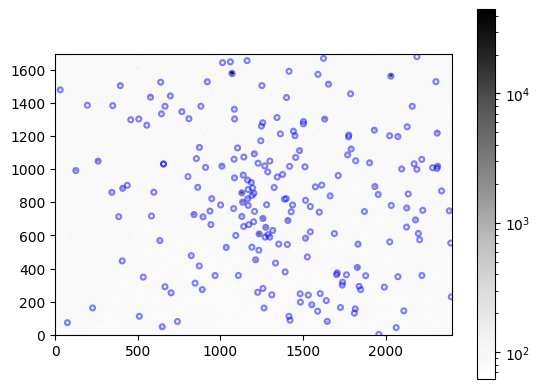

In [12]:
plt.figure()
plt.imshow(section1,origin='lower',norm=LogNorm(),cmap='Greys',interpolation = 'nearest')
apertures.plot(color='blue',lw=1.5,alpha=0.5);

plt.colorbar()
plt.show

### Masks

Might not be needed if you don't have saturated stars

In [51]:
mask = np.zeros(image_data.shape,dtype=bool)

mask[0:1500,0:1500] = True #A random mask so you can see what it does

<function matplotlib.pyplot.show(close=None, block=None)>

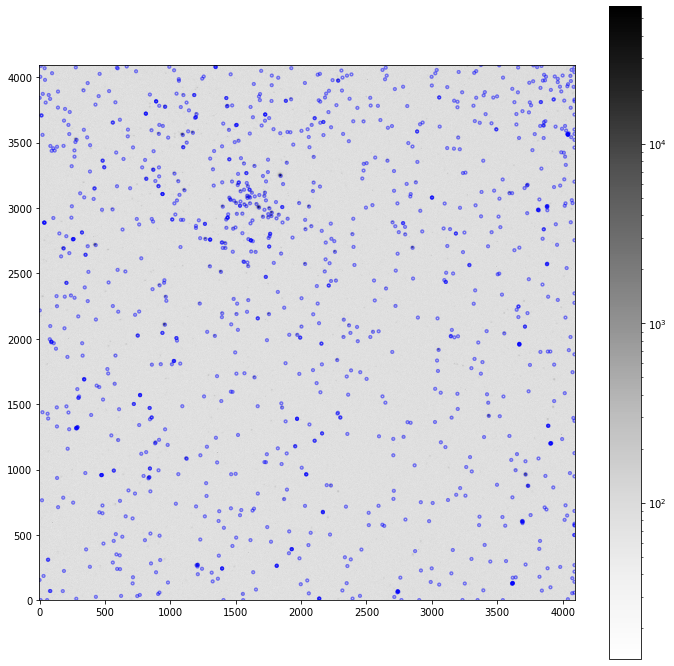

In [52]:
sources=daofind(image_data-median,mask=mask)
xpix=sources['xcentroid']
ypix=sources['ycentroid']

postions = np.transpose((xpix,ypix))
apertures = CircularAperture(positions,r=10.0)

plt.figure(figsize=(12,12))
plt.imshow(image_data,origin='lower',norm=LogNorm(),cmap='Greys',interpolation = 'nearest')
apertures.plot(color='blue',lw=1.5,alpha=0.5);

plt.colorbar()
plt.show

# Aperture Photometry

In [32]:
#We want to use the unmasked one. 
sources=daofind(section1-median)

for col in sources.colnames:
    if col not in ('id','npix'):
        sources[col].info.format='%.2f'
        
sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1   1958.44      1.60      0.53      -0.05 ... 0.00    74.62   2.26 -0.89
  2   2063.21     42.75      0.37      -0.13 ... 0.00    95.06   2.09 -0.80
  3    648.36     47.95      0.41      -0.07 ... 0.00   516.47   7.70 -2.22
  4     74.73     72.40      0.30      -0.19 ... 0.00    92.20   1.37 -0.34
  5    740.22     79.53      0.48      -0.04 ... 0.00    57.31   1.06 -0.06
  6   1646.38     80.34      0.41      -0.13 ... 0.00  1380.79  27.15 -3.58
  7   1421.10     87.13      0.54      -0.38 ... 0.00    54.51   1.14 -0.14
  8    509.73    110.94      0.35      -0.07 ... 0.00    83.07   1.38 -0.35
  9   1414.90    110.89      0.38      -0.20 ... 0.00   245.79   5.11 -1.77
 10   1810.26    129.72      0.45      -0.18 ... 0.00    90.29   2.00 -0.75
...       ...       ...       ...        ... ...  ...      ...    ...   ...
204    920.7

In [14]:
positions=np.transpose((sources['xcentroid'],sources['ycentroid'])) #Because python does yx.
apertures = CircularAperture(positions,r=15.0)

In [15]:
print(apertures)

Aperture: CircularAperture
positions: [[1.95843658e+03, 1.60278807e+00],
            [2.06320794e+03, 4.27508908e+01],
            [6.48358815e+02, 4.79496845e+01],
            [7.47255321e+01, 7.23987213e+01],
            [7.40219711e+02, 7.95312230e+01],
            [1.64637922e+03, 8.03429124e+01],
            [1.42109951e+03, 8.71313775e+01],
            [5.09727098e+02, 1.10944585e+02],
            [1.41490077e+03, 1.10887629e+02],
            [1.81026369e+03, 1.29718490e+02],
            [1.58825513e+03, 1.41837158e+02],
            [2.10943857e+03, 1.44062005e+02],
            [1.81602440e+03, 1.56109461e+02],
            [1.26396011e+03, 1.60911682e+02],
            [2.27074943e+02, 1.61605768e+02],
            [1.72627369e+03, 1.64134240e+02],
            [1.55306184e+03, 1.80882742e+02],
            [1.48394647e+03, 1.96426459e+02],
            [1.64053898e+03, 2.05962251e+02],
            [2.39670902e+03, 2.28711141e+02],
            [1.53172568e+03, 2.38984226e+02],
       

## Making an Annulus for the Background

In [16]:
annulus_aperture = CircularAnnulus(positions, r_in=27, r_out=41) # Set these to the ideal innder and outer apertures. 

<function matplotlib.pyplot.show(close=None, block=None)>

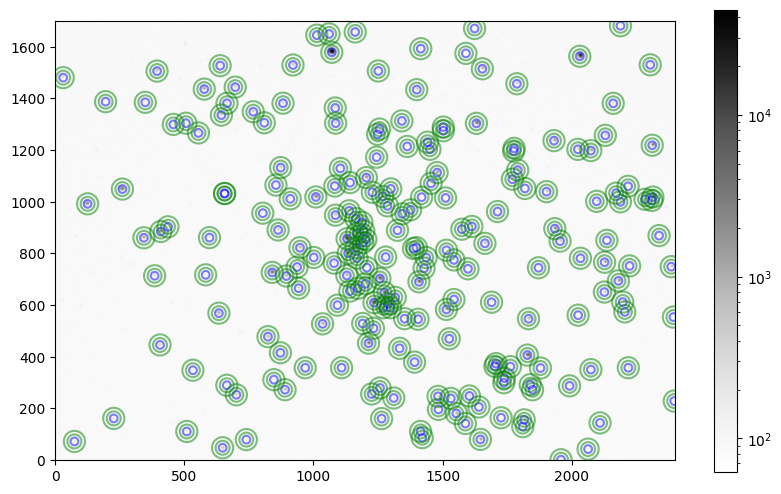

In [18]:
plt.figure(figsize=(10,6))
plt.imshow(section1,origin='lower',norm=LogNorm(),cmap='Greys',interpolation = 'nearest')
apertures.plot(color='blue',lw=1.5,alpha=0.5);
annulus_aperture.plot(color='green',lw=1.5,alpha=0.5)
plt.colorbar()
plt.show

In [19]:
star_data = aperture_photometry(section1,apertures)

In [20]:
bkg = aperture_photometry(section1,annulus_aperture)
bkg_area = annulus_aperture.area_overlap(section1)
aperture_area = apertures.area_overlap(section1)
bkg_total = (bkg['aperture_sum']/bkg_area)*aperture_area #deals with different sizes of the apertures

In [21]:
star_data['total_bkg']=bkg_total
star_data['bkg_area']=bkg_area
star_data['aperture_area']=aperture_area
star_data['star_count']=star_data['aperture_sum']-star_data['total_bkg']


for col in star_data.colnames:
    star_data[col].info.format='%.8g'

star_data.pprint

<bound method Table.pprint of <QTable length=214>
  id   xcenter   ycenter  aperture_sum ...  bkg_area aperture_area star_count
         pix       pix                 ...                                   
int64  float64   float64    float64    ...  float64     float64     float64  
----- --------- --------- ------------ ... --------- ------------- ----------
    1 1958.4366 1.6027881    37945.369 ... 1554.3154     416.30558  3279.8458
    2 2063.2079 42.750891    66659.504 ... 2990.7962     706.85835  8252.3874
    3 648.35881 47.949685     121748.6 ... 2990.7962     706.85835   62901.64
    4 74.725532 72.398721    75615.939 ... 2990.7962     706.85835  14333.948
    5 740.21971 79.531223    66287.576 ... 2990.7962     706.85835  7680.8443
    6 1646.3792 80.342912    174629.36 ... 2990.7962     706.85835  116217.55
    7 1421.0995 87.131377    63142.769 ... 2990.7962     706.85835  3257.1072
    8  509.7271 110.94459    69507.579 ... 2990.7962     706.85835   10619.36
    9 1414.900

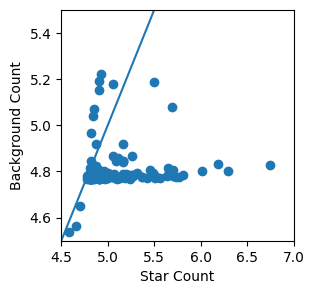

In [28]:
plt.figure(figsize=(3,3))
plt.scatter(np.log10(star_data['aperture_sum']),np.log10(star_data['total_bkg']))
plt.xlabel('Star Count')
plt.ylabel('Background Count')
plt.plot([4.5,7],[4.5,7])
plt.xlim(4.5, 7)
plt.ylim(4.5, 5.5)
plt.show()


### Instrumental Magnitudes

These are just -2.5 log10 (counts)

You can't do it for when the background is greater than the star flux.

In [25]:
star_data_good=star_data[(star_data['star_count']>0)]
star_data_good['inst_mag_r']=-2.5*np.log10(star_data_good['star_count'])

star_data_good

id,xcenter,ycenter,aperture_sum,total_bkg,bkg_area,aperture_area,star_count,inst_mag_r
,pix,pix,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,1958.4366,1.6027881,37945.369,34665.523,1554.3154,416.30558,3279.8458,-8.7896336
2,2063.2079,42.750891,66659.504,58407.116,2990.7962,706.85835,8252.3874,-9.791449
3,648.35881,47.949685,121748.6,58846.961,2990.7962,706.85835,62901.64,-11.996655
4,74.725532,72.398721,75615.939,61281.99,2990.7962,706.85835,14333.948,-10.390915
5,740.21971,79.531223,66287.576,58606.732,2990.7962,706.85835,7680.8443,-9.7135224
6,1646.3792,80.342912,174629.36,58411.814,2990.7962,706.85835,116217.55,-12.663179
7,1421.0995,87.131377,63142.769,59885.661,2990.7962,706.85835,3257.1072,-8.7820801
8,509.7271,110.94459,69507.579,58888.219,2990.7962,706.85835,10619.36,-10.065246


# Do the second filter

Now do the same stuff for the second filter. I'll do g-band. 

You should check the seeing FWHM in this filter, but really should use the same apertures for both filters. Ill use the r-band one. They are about the same. 

![image](Seeing_Profile_gband.png)


In [47]:
fits_file = fits.open('aligned_ngc884_MED_aligned_g.fits')
image_data=fits_file[0].data

<function matplotlib.pyplot.show(close=None, block=None)>

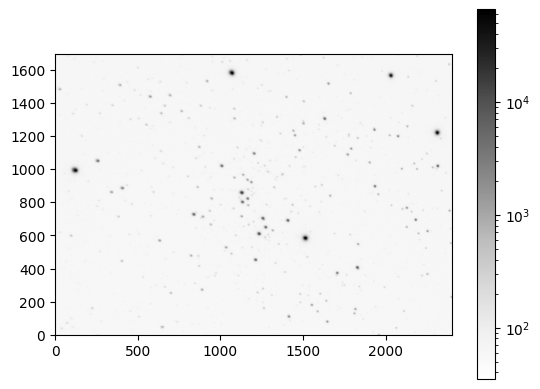

In [48]:
section1 = image_data[2300:4000, 100:2500]
plt.figure()
plt.imshow(section1,origin='lower',norm=LogNorm(),cmap='Greys')
plt.colorbar()
plt.show

It's actually a good idea to use the list of sources from the first image. Then you will have a measurement for the same positions (this is why we lined up the two filters first).

In [49]:
apertures_g = CircularAperture(positions,r=15.0) # This is the 1.5 FWHM as measured from the image using AIJ

In [50]:
annulus_aperture_g = CircularAnnulus(positions, r_in=27, r_out=41) # Set these to the ideal innder and outer apertures. 

<function matplotlib.pyplot.show(close=None, block=None)>

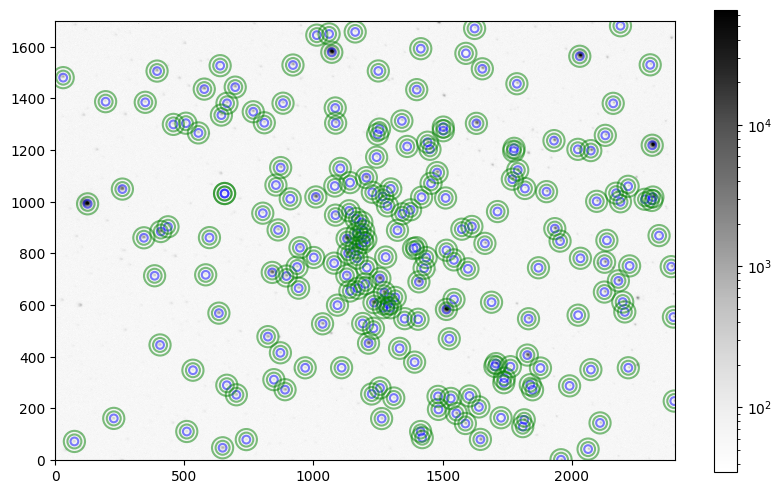

In [51]:
plt.figure(figsize=(10,6))
plt.imshow(section1,origin='lower',norm=LogNorm(),cmap='Greys',interpolation = 'nearest')
apertures_g.plot(color='blue',lw=1.5,alpha=0.5);
annulus_aperture_g.plot(color='green',lw=1.5,alpha=0.5)
plt.colorbar()
plt.show

In [52]:
star_data_g = aperture_photometry(section1,apertures_g)

In [53]:
bkg = aperture_photometry(section1,annulus_aperture_g)
bkg_area = annulus_aperture_g.area_overlap(section1)
aperture_area = apertures_g.area_overlap(section1)
bkg_total = (bkg['aperture_sum']/bkg_area)*aperture_area #deals with different sizes of the apertures

In [54]:
star_data['total_bkg_g']=bkg_total
star_data['bkg_area_g']=bkg_area
star_data['aperture_area_g']=aperture_area
star_data['star_count_g']=star_data_g['aperture_sum']-star_data['total_bkg_g']


for col in star_data.colnames:
    star_data[col].info.format='%.8g'

star_data.pprint(max_width=76)

 id  xcenter   ycenter  ... bkg_area_g aperture_area_g star_count_g
       pix       pix    ...                                        
--- --------- --------- ... ---------- --------------- ------------
  1 1958.4366 1.6027881 ...  1554.3154       416.30558    27862.811
  2 2063.2079 42.750891 ...  2990.7962       706.85835    25997.948
  3 648.35881 47.949685 ...  2990.7962       706.85835    95130.446
  4 74.725532 72.398721 ...  2990.7962       706.85835    18636.608
  5 740.21971 79.531223 ...  2990.7962       706.85835     12802.84
  6 1646.3792 80.342912 ...  2990.7962       706.85835    128725.01
  7 1421.0995 87.131377 ...  2990.7962       706.85835   -7326.2467
  8  509.7271 110.94459 ...  2990.7962       706.85835     15096.07
  9 1414.9008 110.88763 ...  2990.7962       706.85835     211324.2
 10 1810.2637 129.71849 ...  2990.7962       706.85835    50237.664
...       ...       ... ...        ...             ...          ...
205 2303.6905 1530.2794 ...  2990.7962       706

In [55]:
#Do both instrumental magnitudes

star_data_good=star_data[(star_data['star_count']>0) & (star_data['star_count_g']>0)]
star_data_good['inst_mag_r']=-2.5*np.log10(star_data_good['star_count'])
star_data_good['inst_mag_g']=-2.5*np.log10(star_data_good['star_count_g'])

star_data_good.pprint

<bound method Table.pprint of <QTable length=200>
  id   xcenter   ycenter  aperture_sum ... star_count_g inst_mag_r inst_mag_g
         pix       pix                 ...                                   
int64  float64   float64    float64    ...   float64     float64    float64  
----- --------- --------- ------------ ... ------------ ---------- ----------
    1 1958.4366 1.6027881    37945.369 ...    27862.811 -8.7896336 -11.112562
    2 2063.2079 42.750891    66659.504 ...    25997.948  -9.791449 -11.037348
    3 648.35881 47.949685     121748.6 ...    95130.446 -11.996655 -12.445799
    4 74.725532 72.398721    75615.939 ...    18636.608 -10.390915 -10.675917
    5 740.21971 79.531223    66287.576 ...     12802.84 -9.7135224 -10.268266
    6 1646.3792 80.342912    174629.36 ...    128725.01 -12.663179 -12.774157
    8  509.7271 110.94459    69507.579 ...     15096.07 -10.065246  -10.44716
    9 1414.9008 110.88763    79720.548 ...     211324.2 -10.818839 -13.312373
   11 1588.255

# Colour Magnitude Diagram

(-8.0, -16.0)

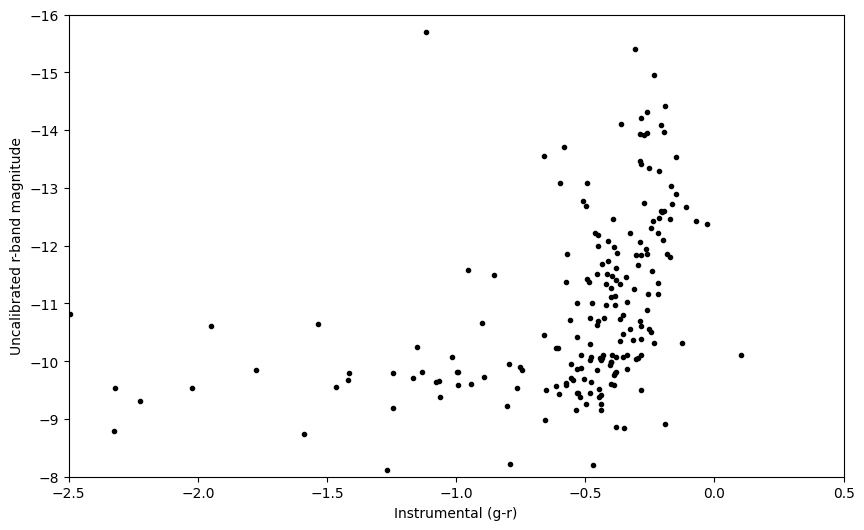

In [58]:
r = star_data_good['inst_mag_r']
grcolor = star_data_good['inst_mag_g'] - star_data_good['inst_mag_r']

plt.figure(figsize=(10,6))
plt.plot(grcolor, r, '.k')
plt.xlabel ('Instrumental (g-r)')
plt.ylabel ('Uncalibrated r-band magnitude')
plt.xlim(-2.5,0.5)
plt.ylim(-8,-16)
